In [30]:
import pandas as pd 
import xarray as xr 
import matplotlib.pyplot as plt
import numpy as np

In [62]:
file_name_dict = {"provinciehuis" : ("Provinciehuis", (3.728, 51.051)), 
                  "melle" : ("Melle", (3.816, 50.980)), 
                  "honda" : ("Honda", (3.749, 51.109)), 
                  "wondelgem" : ("Wondelgem", (3.703, 51.084)), 
                  "plantentuin" : ("Plantentuin", (3.722, 51.036)), 
                  "sintbavo" : ("Sint-Bavo", (3.732, 51.052))}

for file_name in file_name_dict.keys():
    print(file_name)
    file_path = f"../data/{file_name}.csv"
    new_file_path = f"../data/{file_name}_clean.csv"
    file = open(file_path)
    new_file = open(new_file_path, "w")
    new_file.write("year,month,day,hour,minutes,seconds,temperature,?\n")

    for line in file:
        line_list = line.strip().split(",")
        if len(line_list) == 9:
            assert line_list[-3] == ''
            line_list = line_list[:6] + line_list[-2:]
        
        new_line = ",".join(line_list)
        new_file.write(new_line + "\n")

    new_file.close()
    file.close()

provinciehuis
melle
honda
wondelgem
plantentuin
sintbavo


In [68]:
ds_list = list()

for file_name in file_name_dict.keys():
    print(file_name)
    df = pd.read_csv(f"../data/{file_name}_clean.csv")

    ds_raw = xr.Dataset.from_dataframe(df)
    time_list = list()

    for index in ds_raw.index:
        time_list.append(np.datetime64(f"{ds_raw.year[index].values}-{ds_raw.month[index].values:02d}-{ds_raw.day[index].values:02d}T{ds_raw.hour[index].values:02d}", "ns"))

    ds_raw = ds_raw.assign_coords({"time":("index", time_list)})
    ds = ds_raw.swap_dims(index="time")
    ds["time"] = np.array(ds.time, dtype='datetime64[ns]')
    ds = ds.set_coords(['year', 'month', 'day', 'hour'])
    ds = ds.drop_vars(["minutes", "seconds", "?"])

    ds = ds.rename(temperature="tas")
    ds["tas"].attrs = {"standard_name" : "air_temperature", "long_name" : "Near-Surface Air Temperature", "units" : "°C", "cell_methods" : "time: point"}

    file_info = file_name_dict[file_name]
    location = file_info[0]
    lon, lat = file_info[1]

    ds = ds.assign_coords({"lon" : lon, "lat" : lat, "location" : location})
    ds_list.append(ds)

provinciehuis
melle
honda
wondelgem
plantentuin
sintbavo


In [75]:
ds = xr.concat(ds_list, dim="location")
ds.to_netcdf("../data/MOCCA_tas.nc", engine="netcdf4")

In [80]:
tstart = "2019-07-22T01"
tstop = "2019-07-27T00"

ds_sel = ds.sel(time=slice(tstart, tstop))
ds_sel.to_netcdf(f"../data/MOCCA_tas_{tstart}_{tstop}.nc", engine="netcdf4")

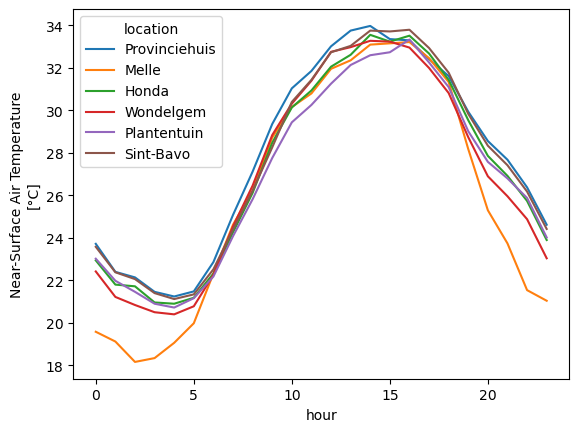

In [82]:
ds_sel.tas.groupby("hour").mean().plot(hue="location")